In [81]:
# pip install -U dataprep

In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, timedelta

# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve,f1_score

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path = '/kaggle/input/sf-dst-scoring/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Функции

In [83]:
'''Функция, возвращающая порядковый день в году'''

def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day

'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''

def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    

'''Функция, возвращающая флаг подачи заявки в выходной день'''

def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0
    
    
def month(x):
    month = x.month
    return month
    

In [84]:
def get_boxplot(data,col1,col2,hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue,data=data, palette='mako')
    plt.xticks(rotation=45)
#     ax.set_title('Boxplot for ' + col1 + 'and' + col2,fontsize=14)
    ax.set_title(f'Boxplot for {col1} and {col2}',fontsize=14)
    plt.show()

In [85]:
'''Функция, определяющая флаг наличия поручителя среди людей с образованием 'PGR' и 'ACD'  '''
def has_no_garant(edu,grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt             
    else: 
        grnt = 0
        return grnt
    

In [86]:
class Preprocessing:
    def __init__(self,data):
        self.data = data
#         self.column = column
    
    def label_encoder(self,column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])
        
        
    def hot_enc(self,column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names(['hot_encode'])
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data


In [87]:
def corr_matrix(data, det=True, pltx = 10, plty=10):
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinat of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,cmap='mako',annot=True,square=True)
    plt.show()

In [88]:
def pre_processing(column,data):
    '''Function is called to encode feature'''
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Загрузка данных

In [89]:
# train = pd.read_csv(path+'train.csv')
# test = pd.read_csv(path+'test.csv')
# sub = pd.read_csv(path+'sample_submission.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)
Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)


In [90]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [91]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [92]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [93]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [94]:
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test], axis=0)

client_id           0.0
education           0.0
sex                 0.0
age                 0.0
car                 0.0
car_type            0.0
decline_app_cnt     0.0
good_work           0.0
score_bki           0.0
bki_request_cnt     0.0
region_rating       0.0
home_address        0.0
work_address        0.0
income              0.0
sna                 0.0
first_time          0.0
foreign_passport    0.0
default             0.0
test                0.0
days_numb           0.0
days_beetwen        0.0
month               0.0
has_no_guarantor    0.0
dtype: float64


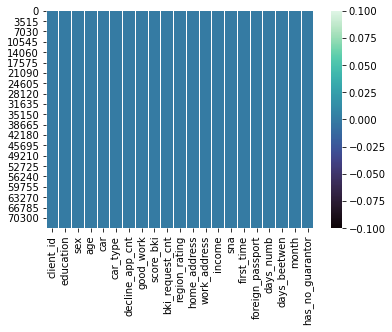

In [151]:
sns.heatmap(train.drop(['default','test'],axis=1).isnull(), cmap='mako')
print(train.isna().mean() * 100) # ВЫражаем пропуски в процентах

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [96]:
# pandas_profiling.ProfileReport(df.drop(['client_id','default','test'],axis=1))

In [97]:
train[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,0


In [98]:
edu_name = train['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = train['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = train['education'].isnull() # Флаги с наличием пропусков
train.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(train[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

<AxesSubplot:>

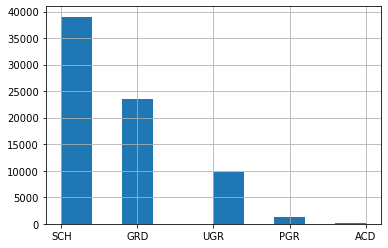

In [99]:
train['education'].hist()

## 1.Анализ данных

<function matplotlib.pyplot.show(close=None, block=None)>

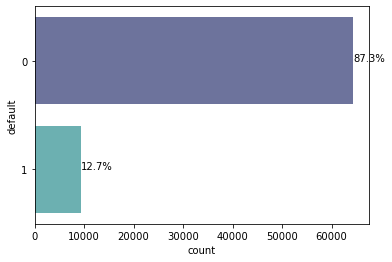

In [158]:
ax = sns.countplot(y='default', data= train, alpha=0.8,palette='mako')
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage,(x,y))
plt.show


## Имеется дисбаланс классов, попробуем его решить без применения методик по устранению дисбаланса и с ними


client_id        |73799      |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |21         |int64 
good_work        |2          |int64 
score_bki        |69096      |float64 
bki_request_cnt  |38         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |966        |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |int64 
test             |1          |int64 


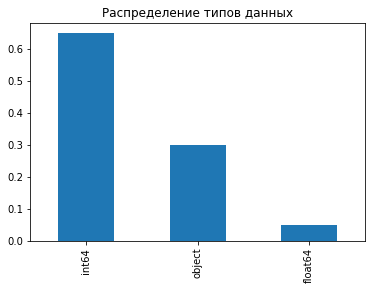

In [101]:
for i in train.columns:
    print('{0:<16} |{1:<10} |{2} '.format(i, train[i].nunique(), train[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

### Исходя из кол-ва возможных значений и описания признаков, делим признаки на числовые, категориальные и бинарные

In [102]:
bin_ = ['sex','car','car_type','foreign_passport','good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt','bki_request_cnt','education','work_address','home_address', 'sna', 'region_rating','first_time']

## Не смотря на то, что признаки  'decline_app_cnt' и 'bki_request_cnt' похожи на числовые с выбросами, мы не будем избавляться от выбросов, но отметим эти признаки как категориальные, т.к. количество запросов в БКИ и количество отказов могут прояснить ситуацию с благополучностью и надежностью потенциального клиента.

### Посмотрим на них поближе



Распределение значений 'decline_app_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






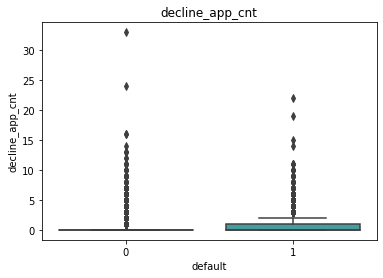



Распределение значений 'bki_request_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






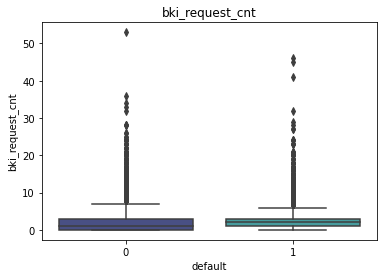

In [103]:
for i in ['decline_app_cnt','bki_request_cnt']:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i],palette='mako')
    print('\n\nРаспределение значений \'{0}\'\n\n{1}\n\n\n\n'.format(i,train["decline_app_cnt"].value_counts()))
    plt.title(i)
    plt.show()


# Числовые признаки

### Преобразуем признак с датой и добавим дополнительные фичи 

In [104]:
train['app_date'] = pd.to_datetime(train['app_date']) # Преобразуем в datetime
train['weekend'] = train['app_date'].apply(lambda x:(if_weekend(x))) # Флаг выходного дня
train['days_numb'] = train['app_date'].apply(lambda x:(get_days_count(x))) # Порядковый номер дня в году
train['days_beetwen'] = train['app_date'].apply(lambda x:(get_days_beetwen(x))) # Кол- во дней между подачей заявки и сегодняшним числом
train['month'] = train['app_date'].apply(lambda x: (month(x)))

In [105]:
train = train.drop('app_date',axis=1) # Удалим столбец app_date 

In [106]:
bin_ = bin_ + ['weekend']
num_ = num_ + ['days_numb','days_beetwen']
cat_ = cat_ + ['month']


In [107]:
train

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen,month
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,18000,4,1,N,0,0,1,31,2625,2
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,19000,4,1,N,0,0,0,72,2586,3
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,30000,1,4,Y,0,0,1,31,2625,2
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,10000,1,3,N,0,0,0,23,2634,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,30000,1,4,Y,0,0,0,108,2549,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,45,N,N,0,0,-1.792064,3,...,17000,4,4,N,0,0,0,64,2594,3
73795,76821,SCH,M,41,Y,Y,0,0,-2.058029,1,...,70000,1,4,N,0,0,0,84,2574,3
73796,103695,SCH,M,31,N,N,0,0,-1.512635,4,...,45000,2,2,N,0,0,0,112,2545,4
73797,861,SCH,F,29,N,N,0,1,-1.479334,3,...,13000,2,3,N,1,0,1,4,2653,1


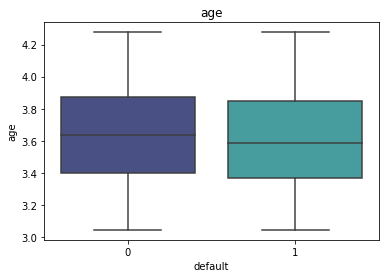

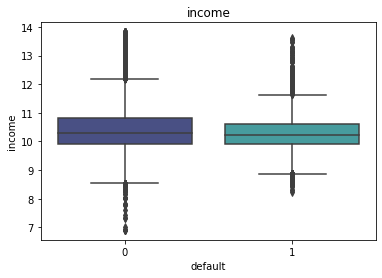

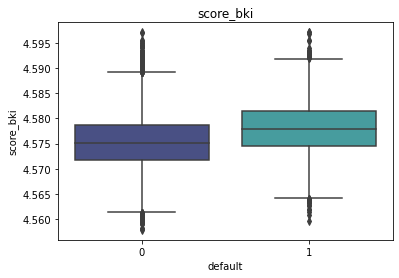

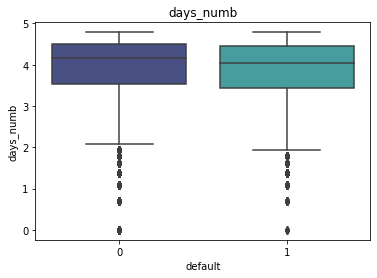

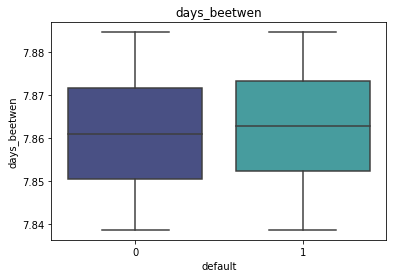

In [156]:
for i in num_:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i],palette='mako')
    plt.title(i)
    plt.show()


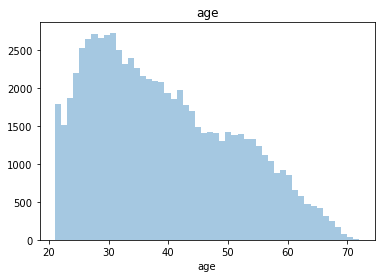

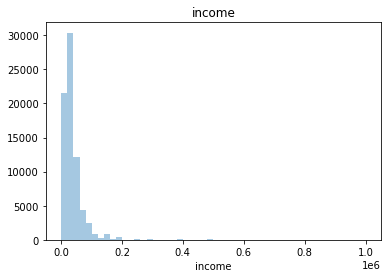

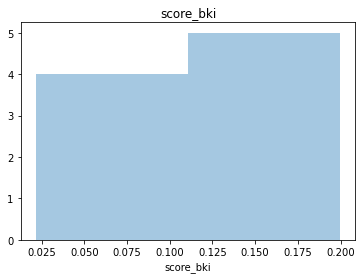

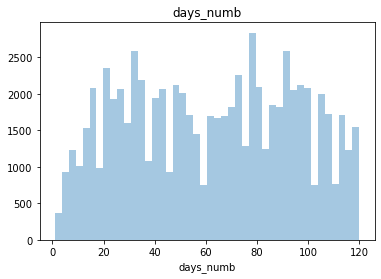

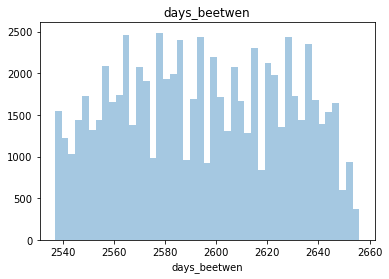

In [109]:
# Построим распределенеие числовых признаков

for i in num_:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [110]:
'''пока не используется'''
# def get_blowout(x):
#     blowouts = dict.fromkeys(['age', 'income', 'score_bki', 'days_numb', 'days_beetwen'])
#     for i in num_:
#         Q1 = np.percentile(df[i],25)
#         Q3 = np.percentile(df[i],75)
#         q_range = Q3 - Q1        
#         right = (df[i][df[i] > (Q3+1.5*q_range)]).values
#         left = (df[i][df[i] < (Q1-1.5*q_range)]).values
#         blowouts.update({i:(set(left),set(right))})
#     return display(blowouts)





   

'пока не используется'

In [111]:
train[['sex','age']].value_counts()

sex  age
M    28     1424
     31     1394
     27     1387
     29     1375
     30     1374
            ... 
     69       18
     70        5
F    72        2
M    71        2
F    71        1
Length: 103, dtype: int64

In [112]:
train[num_]

,age,income,score_bki,days_numb,days_beetwen
0,62,18000,-2.008753,31,2625
1,59,19000,-1.532276,72,2586
2,25,30000,-1.408142,31,2625
3,53,10000,-2.057471,23,2634
4,48,30000,-1.244723,108,2549
...,...,...,...,...,...
73794,45,17000,-1.792064,64,2594
73795,41,70000,-2.058029,84,2574
73796,31,45000,-1.512635,112,2545
73797,29,13000,-1.479334,4,2653


### Видим, что на графиках имеется выраженный хвост вправо. Прологарифмируем.

In [113]:
'''ЛОГАРИФМИРОВАНИЕ'''
train['score_bki'] = train['score_bki'] + 99 # Прибавили число, чтобы избавитья от inf значений 
for col in num_:
    train[col] = np.log(train[col])

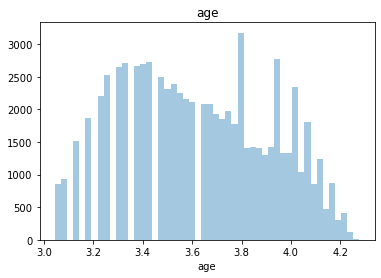

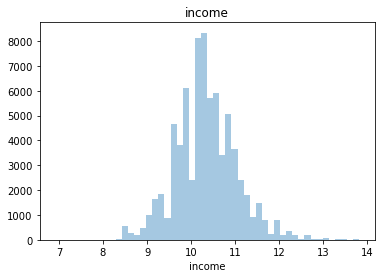

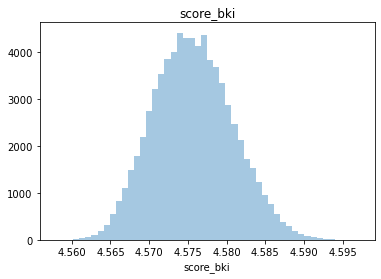

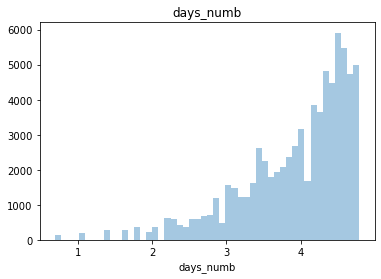

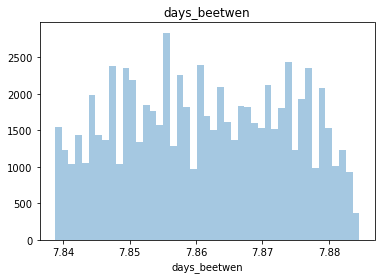

In [114]:
for i in num_:
    plt.figure()
    sns.distplot(train[i][
        train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Rank of Matrix: 5
Determinat of matrix: 0.1367
Shape of matrix: (5, 5)


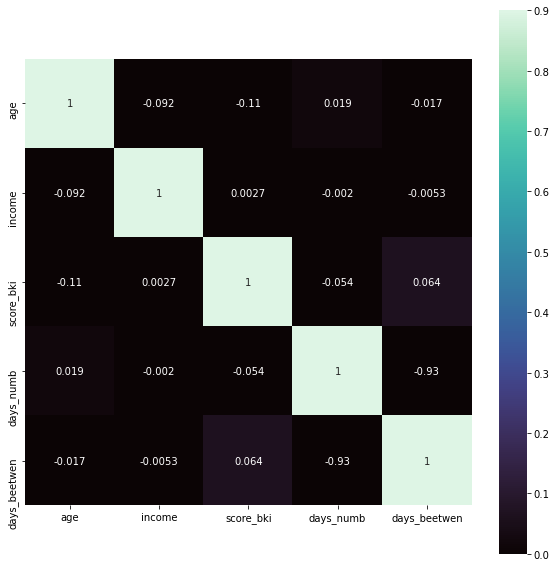

In [115]:
corr_matrix(train[num_])

<AxesSubplot:>

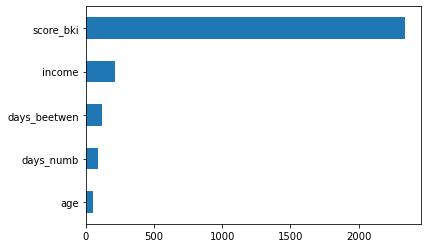

In [116]:
imp_num = Series(f_classif(train[num_], train['default'])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### Большую значимость имеет признак score_bki

In [117]:
# train = train.drop('days_numb',axis = 1 )
# num_.remove('days_numb')

#  Бинарные признаки

### Строим графики бинарных признаков от значения 'default' 

In [118]:
# sns.barplot(x='sex', y='proportion',hue='default' ,  data=df[df['test']==0][['sex','default']].value_counts(normalize=True).rename('proportion').reset_index())

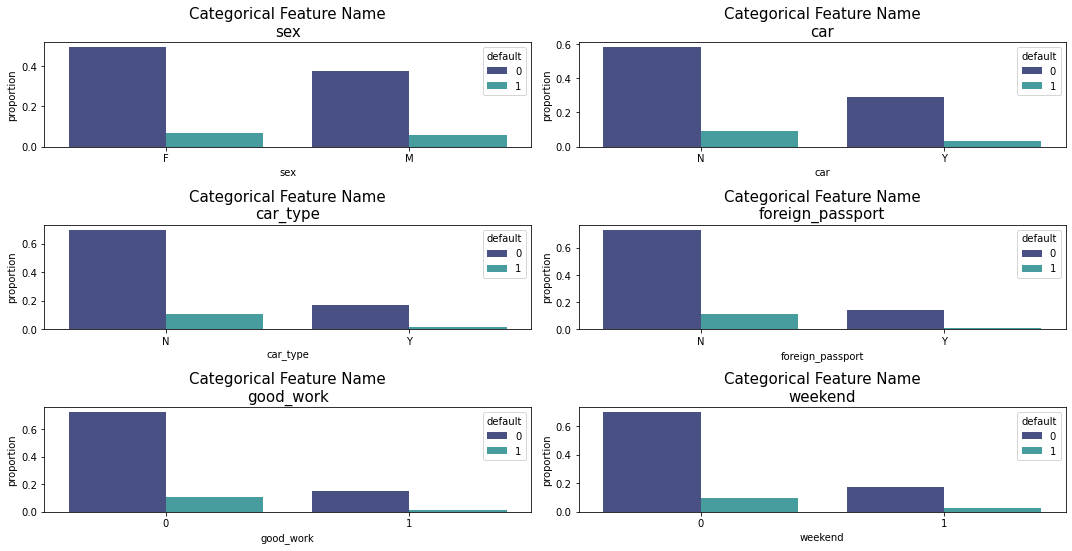

In [119]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in bin_:
    plt.subplot(8, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()    
    

    

Глядя на барплоты, мы можем отметить, что женщины-заемщики, как правило, несут дефолт несколько чаще, чем мужчины.

Заемщики, у которых есть машина, можно считать более надежными. Заемщики, у которых нет машины, как правило, не погашают кредит в два раза чаще, чем те, у кого есть машина.

Те заемщики, у которых есть отечественный автомобиль или нет, склонны к дефолту чаще, чем те, у кого есть иномарка. Однако, если мы хотим видеть распределение более четким, нам нужно создать новую категорию в этом столбце: есть отечественная машина, есть иномарка, нет машины.

Люди, у которых хорошая работа и загранпаспорт, чаще возвращают ссуды, чем те, у кого плохая работа.

Давайте проверим, насколько наши особенности статистически значимы?

Для этого давайте закодируем его в двоичные объекты.

In [120]:
encoder = Preprocessing(train)
for col in bin_:
    encoder.label_encoder(col)

train.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen,month
57578,88783,SCH,0,3.912023,1,1,0,0,4.578056,0,...,9.798127,1,4,0,0,0,1,4.553877,7.848543,4
70104,44901,GRD,1,3.332205,0,0,0,0,4.576553,0,...,10.308953,2,3,0,0,0,0,3.931826,7.865188,2
62998,42532,SCH,0,3.526361,0,0,0,0,4.572494,0,...,10.308953,2,3,0,0,0,0,3.891820,7.865955,2


<AxesSubplot:>

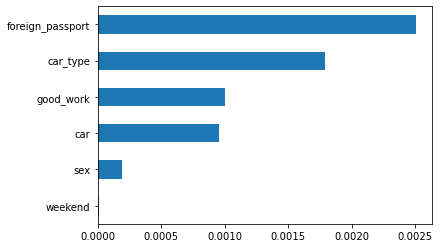

In [121]:
imp_bin = Series(mutual_info_classif(train[bin_], train['default'],
                                     discrete_features=True), index=bin_)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

#### Наиболее важными являются признаки foreign_passport и car_type . Добавленный нами ранее признак флага выходного дня показывает минимальные показатели. Удалим его

In [122]:
train = train.drop('weekend', axis=1)
bin_.remove('weekend')

Rank of Matrix: 5
Determinat of matrix: 0.4583
Shape of matrix: (5, 5)


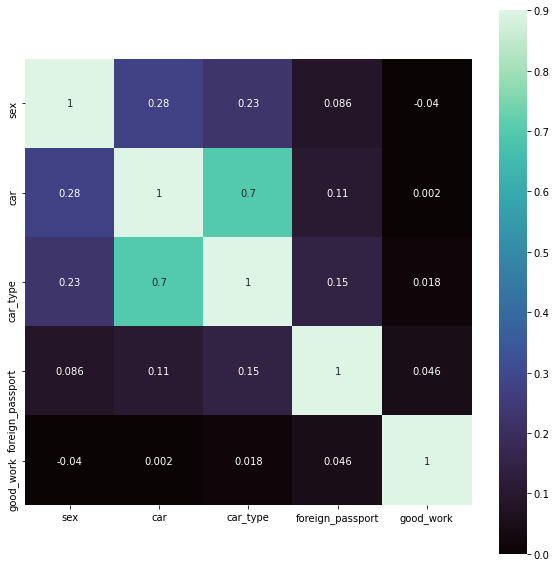

In [123]:
corr_matrix(train[bin_])

У нас сильная корреляция между car и car_type. Это можно объяснить тем, что в столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки, однако отсутствие автомобиля или то, является ли автомобиль отечественным, в car_type не указывается. В разделе проектирования функций мы объединим информацию из этих столбцов в один. Это позволяет уменьшить матрицу характеристик без потери информации.

Кроме того, автомобиль немного коррелирует с полом.

In [124]:
cat_

['decline_app_cnt',
 'bki_request_cnt',
 'education',
 'work_address',
 'home_address',
 'sna',
 'region_rating',
 'first_time',
 'month']

# Категориальные признаки

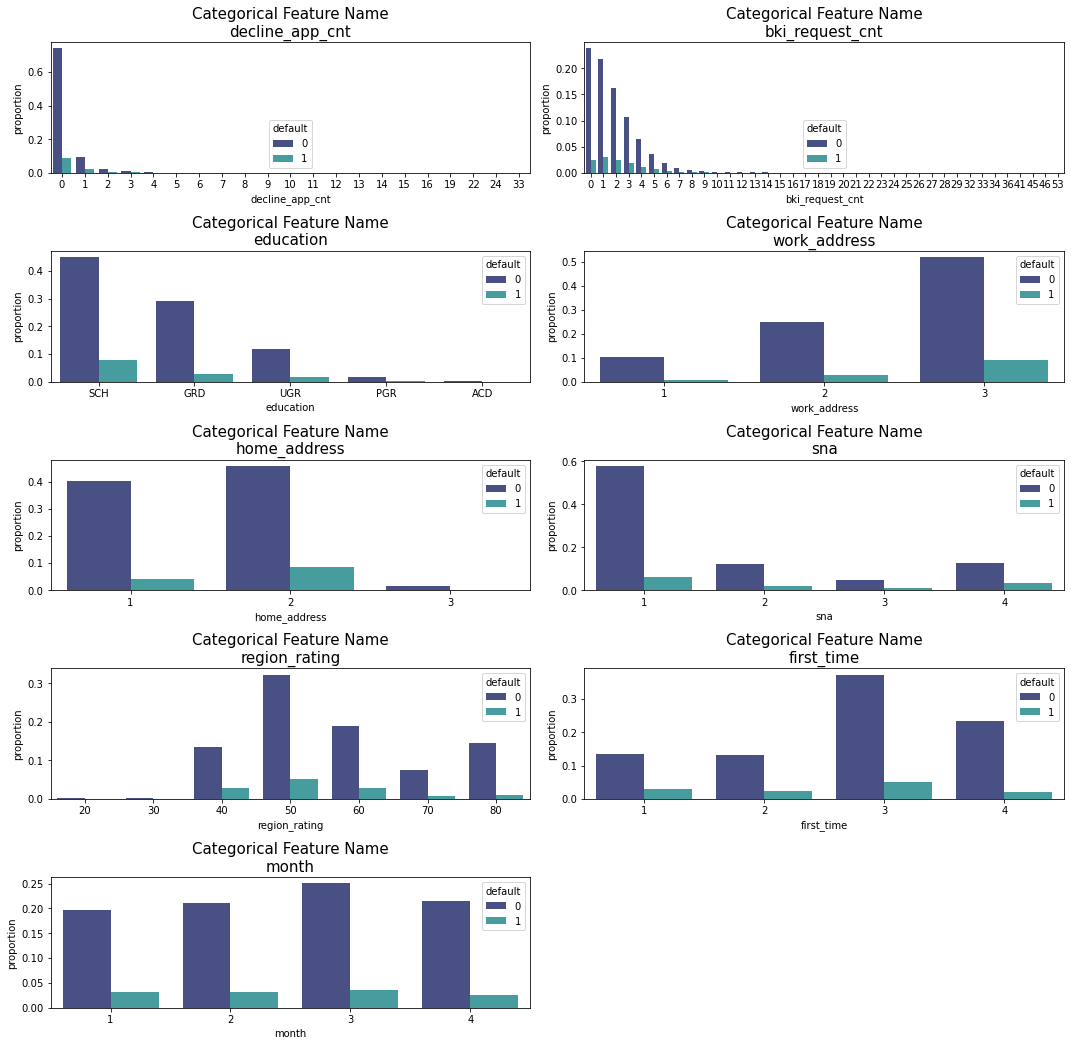

In [125]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in cat_:
    plt.subplot(7, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()    
    

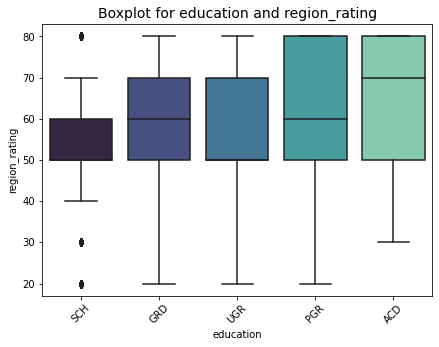

In [126]:
get_boxplot(train,'education','region_rating')

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Хорошо, а теперь давайте посмотрим, как распределяются обанкротившиеся заемщики по region_rating.

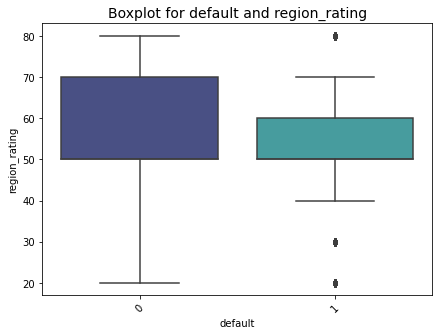

In [127]:
get_boxplot(train,'default','region_rating')

Мы можем видеть, что клиенты по умолчанию живут в регионах среднего уровня. Чем выше рейтинг города, тем меньше вероятность дефолта. Это должно быть хорошее представление для модели.

Интересно, можем ли мы наблюдать какие-то связи между уровнем образования и связью заемщиков с другими клиентами банка? Посмотрим на это.

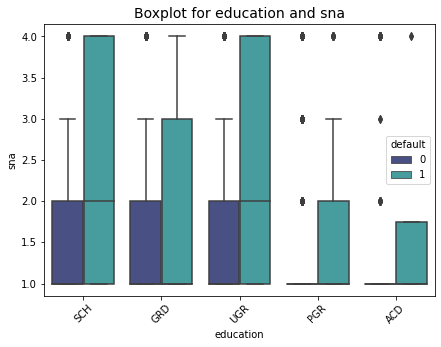

In [128]:
get_boxplot(train,'education','sna',hue='default')

Связи с клиентами банка имеют люди, в основном с низким уровнем образования. Возможно это можно объяснить тем, что люди с низким образованием работают в больших коллективах (заводы, фабрики) и обмен информации лучше или людям с высоким образованием не нужны поручители. Дефолтных клиентов также больше именно в этих категориях.

In [129]:
train['has_no_guarantor'] = 0
train['has_no_guarantor'] = train[['education','has_no_guarantor']].apply(lambda x:has_no_garant(*x),axis=1)

In [130]:
bin_ = bin_ + ['has_no_guarantor']

In [131]:
for col in cat_:
    pre_processing(col,train)

<AxesSubplot:>

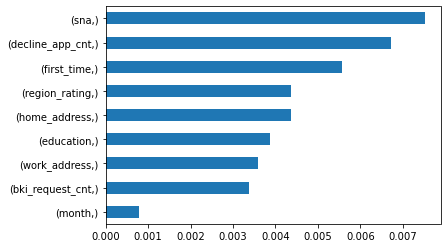

In [132]:
imp_cat = pd.Series(mutual_info_classif(train[cat_], train['default'], 
                                     discrete_features=True), index=[cat_])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 9
Determinat of matrix: 0.278
Shape of matrix: (9, 9)


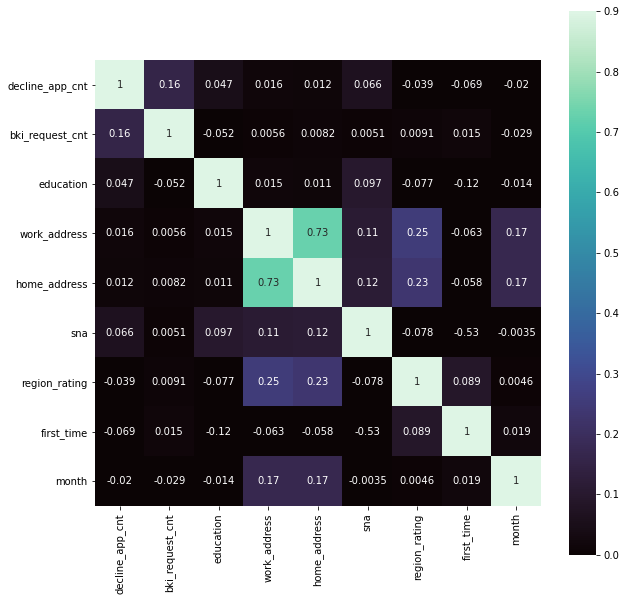

In [133]:
corr_matrix(train[cat_])

У нас довольно сильная корреляция между sna и first_time. Кроме того, эти два столбца имеют наибольшее значение для целевой переменной. Можно предположить, что эти две особенности можно объяснить следующим образом: этот человек давно является клиентом банка и, как следствие, приобрел связи с другими клиентами (возможно, поручителями). Признак меяца имеет статистическое значение. Как-то месяц соотносится с work_address

Домашний и рабочий адреса также коррелировали. Нам нужно подумать, что мы можем сделать с этими признаками

### Посмотрим полную матрицу корреляции

In [134]:
train.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
test                0
days_numb           0
days_beetwen        0
month               0
has_no_guarantor    0
dtype: int64

In [135]:
train

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,test,days_numb,days_beetwen,month,has_no_guarantor
0,25905,3,1,4.127134,1,1,0,0,4.574621,1,...,9.798127,3,0,0,0,0,3.433987,7.872836,1,0
1,63161,3,0,4.077537,0,0,0,0,4.579521,3,...,9.852194,3,0,0,0,0,4.276666,7.857868,2,0
2,25887,3,1,3.218876,1,0,2,0,4.580794,1,...,10.308953,0,3,1,0,0,3.433987,7.872836,1,0
3,16222,3,0,3.970292,0,0,0,0,4.574118,2,...,9.210340,0,2,0,0,0,3.135494,7.876259,0,0
4,101655,1,1,3.871201,0,0,0,1,4.582467,1,...,10.308953,0,3,1,0,0,4.682131,7.843456,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,1,0,3.806662,0,0,0,0,4.576852,3,...,9.740969,3,3,0,0,0,4.158883,7.860956,2,0
73795,76821,3,1,3.713572,1,1,0,0,4.574113,1,...,11.156251,0,3,0,0,0,4.430817,7.853216,2,0
73796,103695,3,1,3.433987,0,0,0,0,4.579723,4,...,10.714418,1,1,0,0,0,4.718499,7.841886,3,0
73797,861,3,0,3.367296,0,0,0,1,4.580064,3,...,9.472705,1,2,0,1,0,1.386294,7.883446,0,0


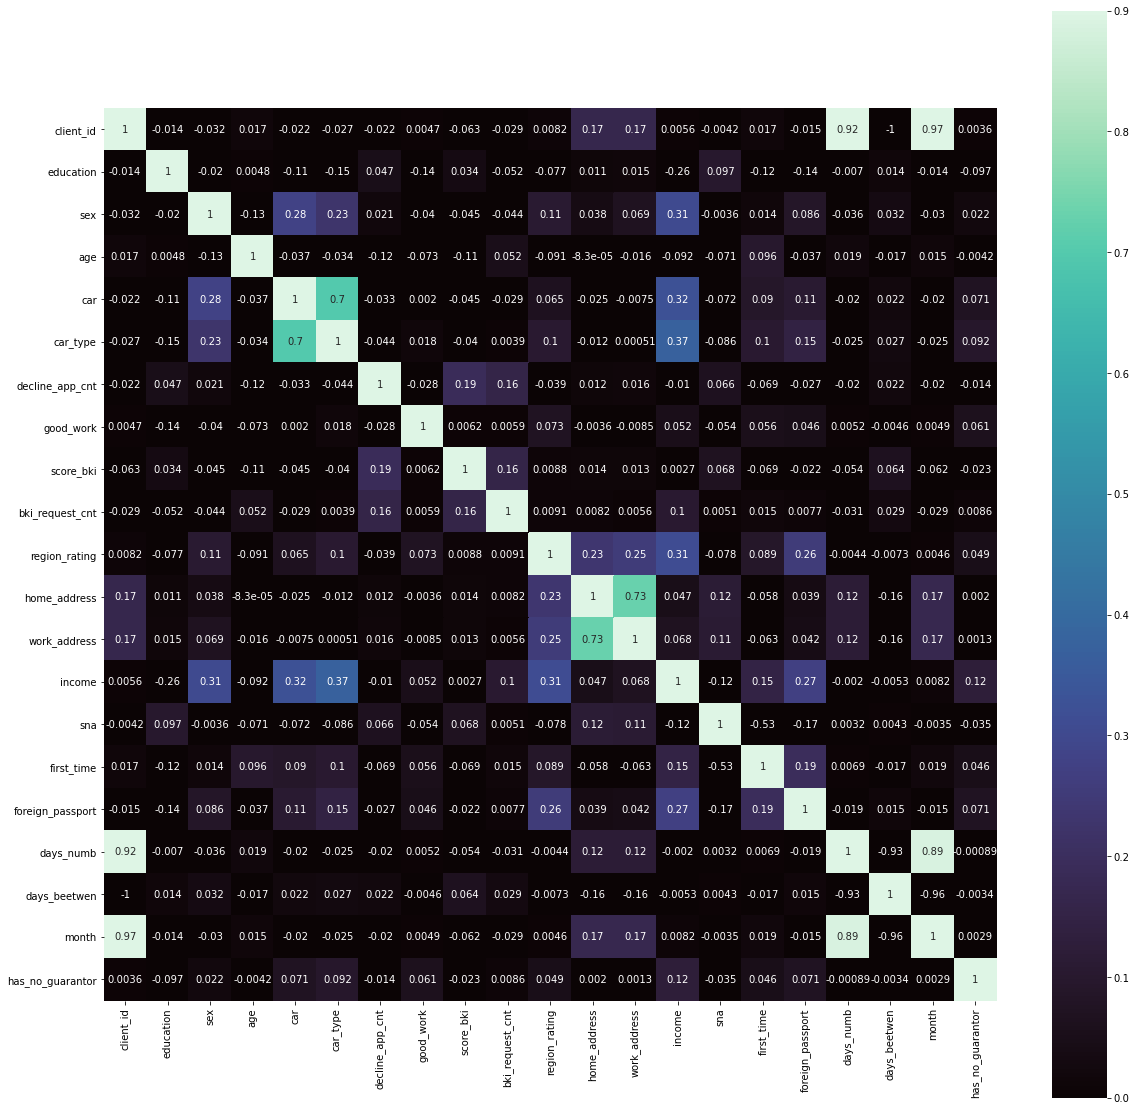

In [136]:
corr_matrix(train.drop(['default','test'],axis=1),det=False,pltx=20,plty=20)

Мы видим полную корреляцию признака client_id и month (порядковый номер дня в году). Это указывает на определенную систему присвоения номера клиента. Скорее всего, эти знаки дадут нам что-нибудь полезное.

car_type коррелирует с доходом. Это можно объяснить предположением, что если у заемщика больше доходов, то у него лучше машина, и наоборот.

sna имеет довольно сильную корреляцию с foreign_passport

> ### Выводы

**Бинарные:**

Автомобиль и car_type сильно коррелированы.

В столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки. Объедините их дальше

Количество дефолтных заемщиков мужского и женского пола практически одинаково. Однако женщины чаще ссужают деньги.

**Категориальные:**

Люди с низким уровнем образования не возвращают кредиты чаще, чем люди с высоким уровнем образования.

Больше отношений заемщика с другими клиентами - больше просроченных платежей. Признак **'has no guarantors'**, может быть добавлен людям с высоким уровнем образования.

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Чем выше рейтинг города, тем меньше вероятность дефолта

Корреляция между **'sna'** и **'first_time'**, **'home_address'** и **'work_address'**.

**Числовые:**

**'score_bki'** имеет распределение близкое к нормальному. Это уже масштабируется ЗППП (скорее всего)

У данных есть выбросы. Тем не менее, лучше некоторые функции преобразовать в категориальный тип.

Нет сильной корреляции между функциями

Car_type коррелирует с доходом

Sna имеет довольно сильную корреляцию с foreign_passport

**Статистически наиболее значимые:**

'foreign_passport'

'car_type'

'sna'

'first_time'

'region_rating'

'Score_bki'

'decline_app_cnt'

Поскольку у нас нет очевидной корреляции и связи между признаками, лучше использовать модели descicion tree или logistic regressions.


# Наивная модель

In [137]:
# X_num_train = RobustScaler().fit_transform(
#     df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_cat_train = OneHotEncoder(sparse=False).fit_transform(
#     df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_bin_train = OneHotEncoder(sparse=False).fit_transform(
#     df_bin[df_bin['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_num_test = RobustScaler().transform(
#     df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_cat_test = OneHotEncoder(sparse=False).fit(
#     df_cat[df_cat['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_bin_test = OneHotEncoder(sparse=False).fit(
#     df_bin[df_bin['test'] == 1].drop(['test', 'default'], axis=1).values)

In [138]:
# scaler_num = RobustScaler()

# X_num_train = scaler.fit_transform(
#     df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_num_test = scaler.transform(
#     df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)

# X_cat_train = OneHotEncoder(sparse=False).fit_transform(df_cat[cat_][df['test'] == 0])
# X_cat_test = OneHotEncoder(sparse=False).fit_transform(df_cat[cat_][df['test'] == 1])

# X_bin_train = df_bin[bin_][df['test']==0]
# X_bin_test = df_bin[bin_][df['test']==1]

In [139]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1


In [140]:
# X_bin_train.shape

In [141]:
# X = np.hstack([X_num_train, X_cat_train, X_bin_train])
# y = df['default'][df['test'] == 0].values
# # X_test = np.hstack([X_num_test, X_cat_test, X_bin_test])


In [142]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=50)

In [143]:
# y_test.shape

In [144]:
# model = LogisticRegression()
# model.fit(X_train,y_train)
# y_pred_proba = model.predict_proba(X_test)
# y_pred_proba = y_pred_proba[:,1]
# y_pred = model.predict(X_test)
# # model.fit(X, y)
# # y_pred_proba = model.predict_proba(X_sub)
# # y_pred = model.predict(X_sub)

In [145]:
# f1_score(y_pred,y_test)

In [146]:
# fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

In [147]:
# id_test = df['client_id'][df['test']==1]

In [148]:
# my_submission = pd.DataFrame({'client_id': id_test, 
#                             'default': y_pred_proba})
# my_submission.to_csv('submission.csv', index=False)

In [149]:
# my_submission